# Predict People with multivariances

In [197]:
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [198]:
import pandas as pd

path = '../data/num_file/hrs_1/p040.csv'
people = pd.read_csv(path, encoding='utf-8')

Merge "date" and "hour" columns to be datetime

In [199]:
people['datetime'] = pd.to_datetime(people['date'])+pd.to_timedelta(people['hour'], unit='h')
people = people.drop(['date', 'hour'], axis=1)
people.set_index('datetime', inplace=True)
people.columns = ['amount']
people['amount'] = people['amount'].astype(float)
print(people)

                      amount
datetime                    
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 12:00:00   1604.0
2022-04-25 15:00:00   4458.0
2022-04-25 16:00:00  18501.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3144 rows x 1 columns]


Resample the data that are not existed

In [200]:
full_index = pd.date_range(start=people.index.min(), end=people.index.max(), freq='h')
people = people.reindex(full_index)
people['amount'] = people['amount'].bfill()
print(people)

                      amount
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 03:00:00   1604.0
2022-04-21 04:00:00   1604.0
2022-04-21 05:00:00   1604.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3251 rows x 1 columns]


Import temperature data.

In [201]:
import os
import pandas as pd

folder_path = '../data/temperature_file/'

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

temperature = []

for file in csv_files:
    file_path = folder_path + file
    df = pd.read_csv(file_path, encoding='utf-8')
    temperature.append(df)

temperature = pd.concat(temperature, ignore_index=True)
    

In [202]:
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
temperature.set_index('datetime', inplace=True)
print(temperature)

                     temperature  precipitation  weather
datetime                                                
2022-07-01 01:00:00         26.1            0.0      NaN
2022-07-01 02:00:00         25.1            0.0      NaN
2022-07-01 03:00:00         24.4            0.0      2.0
2022-07-01 04:00:00         24.0            0.0      NaN
2022-07-01 05:00:00         23.9            0.0      NaN
...                          ...            ...      ...
2022-09-30 20:00:00         20.2            0.0      NaN
2022-09-30 21:00:00         20.3            0.0      1.0
2022-09-30 22:00:00         19.6            0.0      NaN
2022-09-30 23:00:00         18.8            0.0      NaN
2022-10-01 00:00:00         18.8            0.0      NaN

[8760 rows x 3 columns]


Merge the amount of people and temperature data as one dataframe.

In [203]:
data = pd.merge(people, temperature, left_index=True, right_index=True, how='inner')
print(data)

                      amount  temperature  precipitation  weather
2022-04-21 01:00:00   1033.0          9.2            0.0      NaN
2022-04-21 02:00:00     65.0          9.1            0.0      NaN
2022-04-21 03:00:00   1604.0          9.1            0.0      1.0
2022-04-21 04:00:00   1604.0          7.9            0.0      NaN
2022-04-21 05:00:00   1604.0          7.4            0.0      NaN
...                      ...          ...            ...      ...
2022-09-03 07:00:00   9741.0         22.4            0.0      NaN
2022-09-03 08:00:00  19613.0         22.8            0.0      NaN
2022-09-03 09:00:00  22055.0         23.2            0.0      4.0
2022-09-03 10:00:00  14644.0         23.4            0.0      NaN
2022-09-03 11:00:00  12751.0         23.7            0.0      NaN

[3251 rows x 4 columns]


## Data Preprocessing

In [204]:
from sklearn.preprocessing import StandardScaler

In [205]:
scaler = StandardScaler()
data[['amount', 'temperature']] = scaler.fit_transform(data[['amount', 'temperature']])

In [206]:
print(data.head())

                       amount  temperature  precipitation  weather
2022-04-21 01:00:00 -1.608170    -2.122485            0.0      NaN
2022-04-21 02:00:00 -1.752224    -2.140183            0.0      NaN
2022-04-21 03:00:00 -1.523196    -2.140183            0.0      1.0
2022-04-21 04:00:00 -1.523196    -2.352552            0.0      NaN
2022-04-21 05:00:00 -1.523196    -2.441039            0.0      NaN


In [207]:
data = data[['amount', 'temperature']]
print(data)

                       amount  temperature
2022-04-21 01:00:00 -1.608170    -2.122485
2022-04-21 02:00:00 -1.752224    -2.140183
2022-04-21 03:00:00 -1.523196    -2.140183
2022-04-21 04:00:00 -1.523196    -2.352552
2022-04-21 05:00:00 -1.523196    -2.441039
...                       ...          ...
2022-09-03 07:00:00 -0.312280     0.213572
2022-09-03 08:00:00  1.156832     0.284362
2022-09-03 09:00:00  1.520241     0.355151
2022-09-03 10:00:00  0.417365     0.390546
2022-09-03 11:00:00  0.135656     0.443638

[3251 rows x 2 columns]


Slice into dataframe

In [208]:
window_size = 12
def one_step_forecast(df, window=6):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [209]:
test = one_step_forecast(data['amount'], window_size)

In [210]:
y = test['y']
test = test.drop('y', axis=1)
print(test)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -1.608170 -1.752224 -1.523196 -1.523196 -1.523196   
2022-04-21 02:00:00 -1.752224 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 03:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 04:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 05:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
...                       ...       ...       ...       ...       ...   
2022-09-02 19:00:00 -0.145308 -0.533123 -0.693844 -0.831201 -0.654408   
2022-09-02 20:00:00 -0.533123 -0.693844 -0.831201 -0.654408 -0.936266   
2022-09-02 21:00:00 -0.693844 -0.831201 -0.654408 -0.936266 -1.045943   
2022-09-02 22:00:00 -0.831201 -0.654408 -0.936266 -1.045943 -0.828820   
2022-09-02 23:00:00 -0.654408 -0.936266 -1.045943 -0.828820 -0.792807   

                          x_6       x_7       x_8       x_9      x_10  \
2022-04-21 01:00:00 -1.523196 -1.523196 -1.523196 

In [211]:
test_2 = one_step_forecast(data['temperature'], window_size)

In [212]:
test_2.drop('y', axis=1, inplace=True)
print(test_2)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -2.122485 -2.140183 -2.140183 -2.352552 -2.441039   
2022-04-21 02:00:00 -2.140183 -2.140183 -2.352552 -2.441039 -2.246367   
2022-04-21 03:00:00 -2.140183 -2.352552 -2.441039 -2.246367 -1.821630   
2022-04-21 04:00:00 -2.352552 -2.441039 -2.246367 -1.821630 -1.308405   
2022-04-21 05:00:00 -2.441039 -2.246367 -1.821630 -1.308405 -0.972154   
...                       ...       ...       ...       ...       ...   
2022-09-02 19:00:00  0.496730  0.461336  0.408243  0.408243  0.390546   
2022-09-02 20:00:00  0.461336  0.408243  0.408243  0.390546  0.319756   
2022-09-02 21:00:00  0.408243  0.408243  0.390546  0.319756  0.337454   
2022-09-02 22:00:00  0.408243  0.390546  0.319756  0.337454  0.319756   
2022-09-02 23:00:00  0.390546  0.319756  0.337454  0.319756  0.284362   

                          x_6       x_7       x_8       x_9      x_10  \
2022-04-21 01:00:00 -2.246367 -1.821630 -1.308405 

In [213]:
print(y)

2022-04-21 01:00:00   -1.098475
2022-04-21 02:00:00   -1.098475
2022-04-21 03:00:00   -1.098475
2022-04-21 04:00:00   -1.098475
2022-04-21 05:00:00   -1.098475
                         ...   
2022-09-02 19:00:00   -0.312280
2022-09-02 20:00:00    1.156832
2022-09-02 21:00:00    1.520241
2022-09-02 22:00:00    0.417365
2022-09-02 23:00:00    0.135656
Freq: h, Name: y, Length: 3239, dtype: float64


Divide to train and test and val

In [214]:
from sklearn.model_selection import train_test_split

In [215]:
train_people, test_people, train_temperature, test_temperature, train_y, test_y = train_test_split(test, test_2, y, test_size=0.15, shuffle=False)
train_people, val_people, train_temperature, val_temperature, train_y, val_y = train_test_split(train_people, train_temperature, train_y, test_size=0.15, shuffle=False)
index = test_y.index
train_people = np.expand_dims(train_people, axis=-1)
val_people = np.expand_dims(val_people, axis=-1)
test_people = np.expand_dims(test_people, axis=-1)
train_temperature = np.expand_dims(train_temperature, axis=-1)
val_temperature = np.expand_dims(val_temperature, axis=-1)
test_temperature = np.expand_dims(test_temperature, axis=-1)
y_train = np.expand_dims(train_y, axis=-1)
y_val = np.expand_dims(val_y, axis=-1)
y_test = np.expand_dims(test_y, axis=-1)

## Create model

In [216]:
from keras.models import Model
from keras import layers
from keras import Input
from keras.metrics import RootMeanSquaredError as RMSE, MeanAbsoluteError as MAE
from keras import callbacks

In [217]:
people_input = Input(shape=(train_people.shape[1], train_people.shape[2]), name='people')
temperature_input = Input(shape=(train_temperature.shape[1], train_temperature.shape[2]), name='temperature')

In [218]:
print(people_input.shape)

(None, 12, 1)


In [219]:
units = 32
people_lstm = layers.LSTM(units, name='people_lstm')(people_input)
temperature_lstm = layers.LSTM(units, name='temperature_lstm')(temperature_input)

In [220]:
concat= layers.concatenate([people_lstm, temperature_lstm], name='concat')
output = layers.Dense(1, name='output')(concat)

In [221]:
model = Model([people_input, temperature_input], output)

In [222]:
print(model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ people (InputLayer) │ (None, 12, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temperature         │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ people_lstm (LSTM)  │ (None, 32)        │      4,352 │ people[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temperature_lstm    │ (None, 32)        │      4,352 │ temperature[0][0] │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 64)        │          0 │ people_lstm[0][0… │
│ (Concatenate)       │                   │            │ temperature_lstm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [223]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RMSE(), MAE()])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit([train_people, train_temperature], y_train, epochs=200, batch_size=32, shuffle=False, validation_data=([val_people, val_temperature], y_val), callbacks=[es])

Epoch 1/200


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.6921 - mean_absolute_error: 0.7079 - root_mean_squared_error: 0.8284 - val_loss: 0.1404 - val_mean_absolute_error: 0.2941 - val_root_mean_squared_error: 0.3747
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3231 - mean_absolute_error: 0.4370 - root_mean_squared_error: 0.5554 - val_loss: 0.1031 - val_mean_absolute_error: 0.2463 - val_root_mean_squared_error: 0.3208
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2602 - mean_absolute_error: 0.3913 - root_mean_squared_error: 0.4999 - val_loss: 0.0925 - val_mean_absolute_error: 0.2324 - val_root_mean_squared_error: 0.3037
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2269 - mean_absolute_error: 0.3636 - root_mean_squared_error: 0.4671 - val_loss: 0.0855 - val_mean_absolute_error: 0.2238 - val_root_mean_squared_error: 0.2920
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1997 - mean_absolute_error: 0.3402 - root_mean_squared_error: 

In [224]:
eval_result = model.evaluate([test_people, test_temperature], y_test)
print(eval_result)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0596 - mean_absolute_error: 0.1775 - root_mean_squared_error: 0.2371
[0.10611027479171753, 0.20269210636615753, 0.2862265408039093]


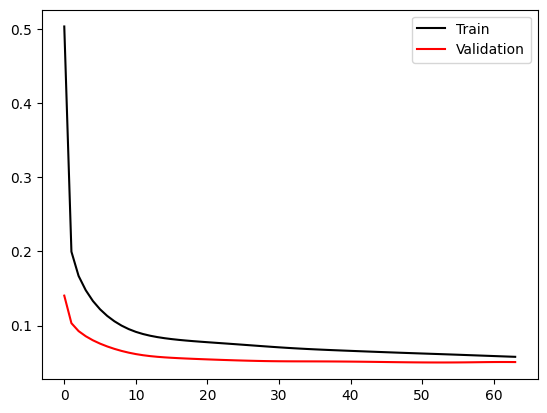

In [225]:
pd.Series(history.history['loss']).plot(style='k')
pd.Series(history.history['val_loss']).plot(style='r')
plt.legend(['Train', 'Validation'])

In [226]:
result = model.predict([test_people, test_temperature])[-1]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [227]:
print(result)

[0.96821946]


In [228]:
result = [result[-1], result[-1]]

In [229]:
result = np.array(result)

In [230]:
result = scaler.inverse_transform(result.reshape(1, -1))

In [231]:
print(result[0][0])

18345.578


In [232]:
res = np.array([test_y.iloc[-1], test_y.iloc[-1]])
res = scaler.inverse_transform(res.reshape(1, -1))
print(res[0][0])

12751.0


In [233]:
result = model.predict([test_people, test_temperature])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [234]:
def plot_forecast(test_y, result, index=index):
    plt.plot(index, test_y, label='actual')
    plt.plot(index, result, label='forecast')
    plt.legend()
    plt.show()

In [235]:
test_y_ex = np.array([test_y, test_y])

In [236]:
test_y_ex = np.array(test_y_ex.T)

In [237]:
print(test_y_ex.shape)

(486, 2)


In [238]:
test_y = scaler.inverse_transform(test_y_ex)

In [239]:
print(test_y[:, 0])

[ 3669.  3910.  4031.  5807.  7202.  9444. 12798. 13134. 14116. 12800.
 11388. 12411. 12229.  7530.  5348.  6680.  6431.  4717.  4047.  4305.
  3997.  3988.  2295.  2416.  3753.  4170.  5492.  6024.  9016. 11629.
 14193. 10913.  8191.  8577.  8610. 10059.  8373.  7772.  6518.  5768.
  4958.  4763.  4491.  4530.  4496.  4118.  2921.  3301.  3335.  4942.
  9130. 10375. 11173. 14430. 16136. 16037. 17111. 16096. 14379. 14793.
 14239. 11939.  9600.  7850.  6463.  5443.  5165.  4924.  4764.  4872.
  3292.  3673.  3958.  5875.  9780. 11876. 12144. 13215. 14322. 18572.
 19070. 18182. 17352. 17554. 16795. 13224. 10401.  7993.  6648.  5902.
  5706.  5297.  5378.  5059.  4250.  4915.  5103.  6708. 12076. 15013.
 15057. 17617. 20683. 23015. 22104. 23203. 23976. 24702. 21751. 22529.
 15821.  9768.  7091.  6484.  7109.  7739.  7487.  7342.  6571.  7518.
  7702.  9944. 13593. 16188. 20538. 22418. 26811. 27704. 23078. 22956.
 23848. 21624. 18722. 16849. 14199. 10909.  8326.  7096.  6627.  6548.
  6438

In [240]:
result = np.array([result[:, 0], result[:, 0]])

In [241]:
result = result.T
print(result.shape)

(486, 2)


In [242]:
result = scaler.inverse_transform(result)

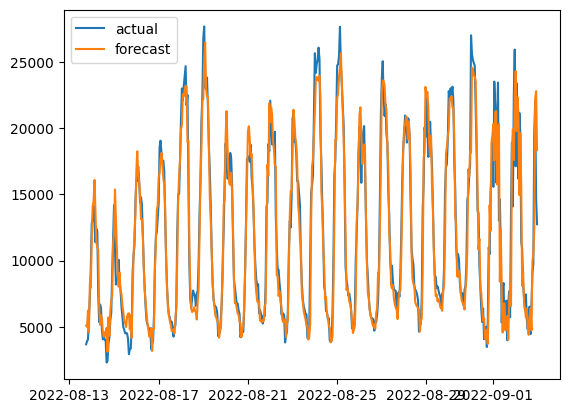

In [243]:
plot_forecast(test_y[:, 0], result[:, 0])

In [244]:
def plot_error(test_y, result):
    error = test_y - result
    plt.plot(index, error, label='error')
    plt.title(f'Error MAE: {np.mean(np.abs(error)):.2f} RMSE: {np.sqrt(np.mean(error**2)):.2f}')
    plt.legend()
    plt.show()

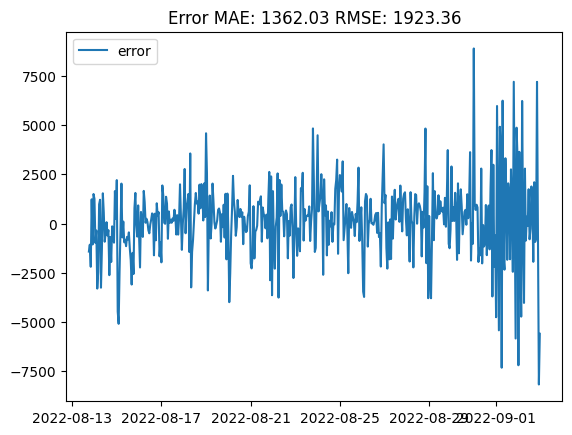

In [245]:
plot_error(test_y[:, 0], result[:, 0])